In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

import csv
import os

/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head(10)

,text,label
0,и что мы бы назвали сложными модусными перспек...,1
1,"Эзофастома бокаловилная, вооружена более крупн...",0
2,", 2008; Durlak et al",1
3,где c0 - концентрация раствора,1
4,При сгруктурном исследовании минерала обнаруже...,0
5,Эпимеральная область (рис,0
6,Человек рассматривается как «рефлексивное живо...,1
7,", на верхушке чуть закругленные (рис",0
8,"Тычинок 2, со свободными, волосисто опушенными...",0
9,"Длина нерок 2.9-3.2 мм, отношение их длины к д...",0


In [4]:
texts = df['text'].tolist()  # Convert to lists
labels = df['label'].tolist()

In [5]:
model_name = "./ofline_models/xlm-roberta-base"
# 1. Load Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # num_classes: number of your classes


# 3. Tokenize and Create Input Tensors
encoded_data = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
labels_tensor = torch.tensor(labels)

# 4. Split Data into Training and Validation Sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels_tensor, test_size=0.2, random_state=42  # Adjust test_size as needed
)
train_masks, val_masks, _, _ = train_test_split(
    attention_mask, input_ids, test_size=0.2, random_state=42
)


# 5. Set up Optimizer
learning_rate = 2e-5 #1e-5, 2e-5, 3e-5, 5e-5.
optimizer = AdamW(model.parameters(), lr=learning_rate)  # Adjust learning rate

2025-02-25 08:37:31.014344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ./ofline_models/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warn

In [6]:
# 6. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the device
batch_size = 32  # Adjust batch size
num_epochs = 6  # Adjust the number of epochs


train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
learning_rates = []  # Lista para guardar el learning rate

# Define the file path
csv_file_path = 'training_metrics_xlm-roberta-base.csv'

# Verifica si el archivo existe y si no, agrega la cabecera
file_exists = os.path.isfile(csv_file_path)
with open(csv_file_path, mode='a', newline='') as file:  # Open ONCE before the loop
    writer = csv.writer(file)

    if not file_exists:  # Write header ONLY if the file doesn't exist
        writer.writerow(['Epoch', 'Train Loss', 'Validation Accuracy', 'Precision', 'Recall', 'F1 Score', 'Learning Rate'])


    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Actualiza el learning rate si es necesario (ejemplo de ajuste)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        model.train()
        epoch_train_loss = 0
        for i in range(0, len(train_inputs), batch_size):
            batch_inputs = train_inputs[i:i+batch_size].to(device)
            batch_labels = train_labels[i:i+batch_size].to(device)
            batch_masks = train_masks[i:i+batch_size].to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
            loss = outputs.loss 
            loss.backward()
            epoch_train_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

        # Promedio de la pérdida en el entrenamiento para esta época
        avg_train_loss = epoch_train_loss / len(train_inputs) * batch_size
        train_losses.append(avg_train_loss)

        # 7. Validación
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for i in range(0, len(val_inputs), batch_size):
                batch_inputs = val_inputs[i:i+batch_size].to(device)
                batch_labels = val_labels[i:i+batch_size].to(device)
                batch_masks = val_masks[i:i+batch_size].to(device)

                outputs = model(batch_inputs, attention_mask=batch_masks)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(batch_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds, average='weighted')
        val_recall = recall_score(val_true, val_preds, average='weighted')
        val_f1 = f1_score(val_true, val_preds, average='weighted')

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        writer.writerow([epoch+1, avg_train_loss, val_accuracy, val_precision, val_recall, val_f1, current_lr])


    # Al finalizar, las métricas se habrán guardado en 'training_metrics.csv'


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Loss: 0.7045, Validation Accuracy: 0.6259, Precision: 0.3917, Recall: 0.6259, F1: 0.4818
Epoch 2: Train Loss: 0.3904, Validation Accuracy: 0.9184, Precision: 0.9185, Recall: 0.9184, F1: 0.9177
Epoch 3: Train Loss: 0.1710, Validation Accuracy: 0.9252, Precision: 0.9275, Recall: 0.9252, F1: 0.9240
Epoch 4: Train Loss: 0.0868, Validation Accuracy: 0.9388, Precision: 0.9399, Recall: 0.9388, F1: 0.9381
Epoch 5: Train Loss: 0.1137, Validation Accuracy: 0.9592, Precision: 0.9598, Recall: 0.9592, F1: 0.9593
Epoch 6: Train Loss: 0.0596, Validation Accuracy: 0.9456, Precision: 0.9498, Recall: 0.9456, F1: 0.9461


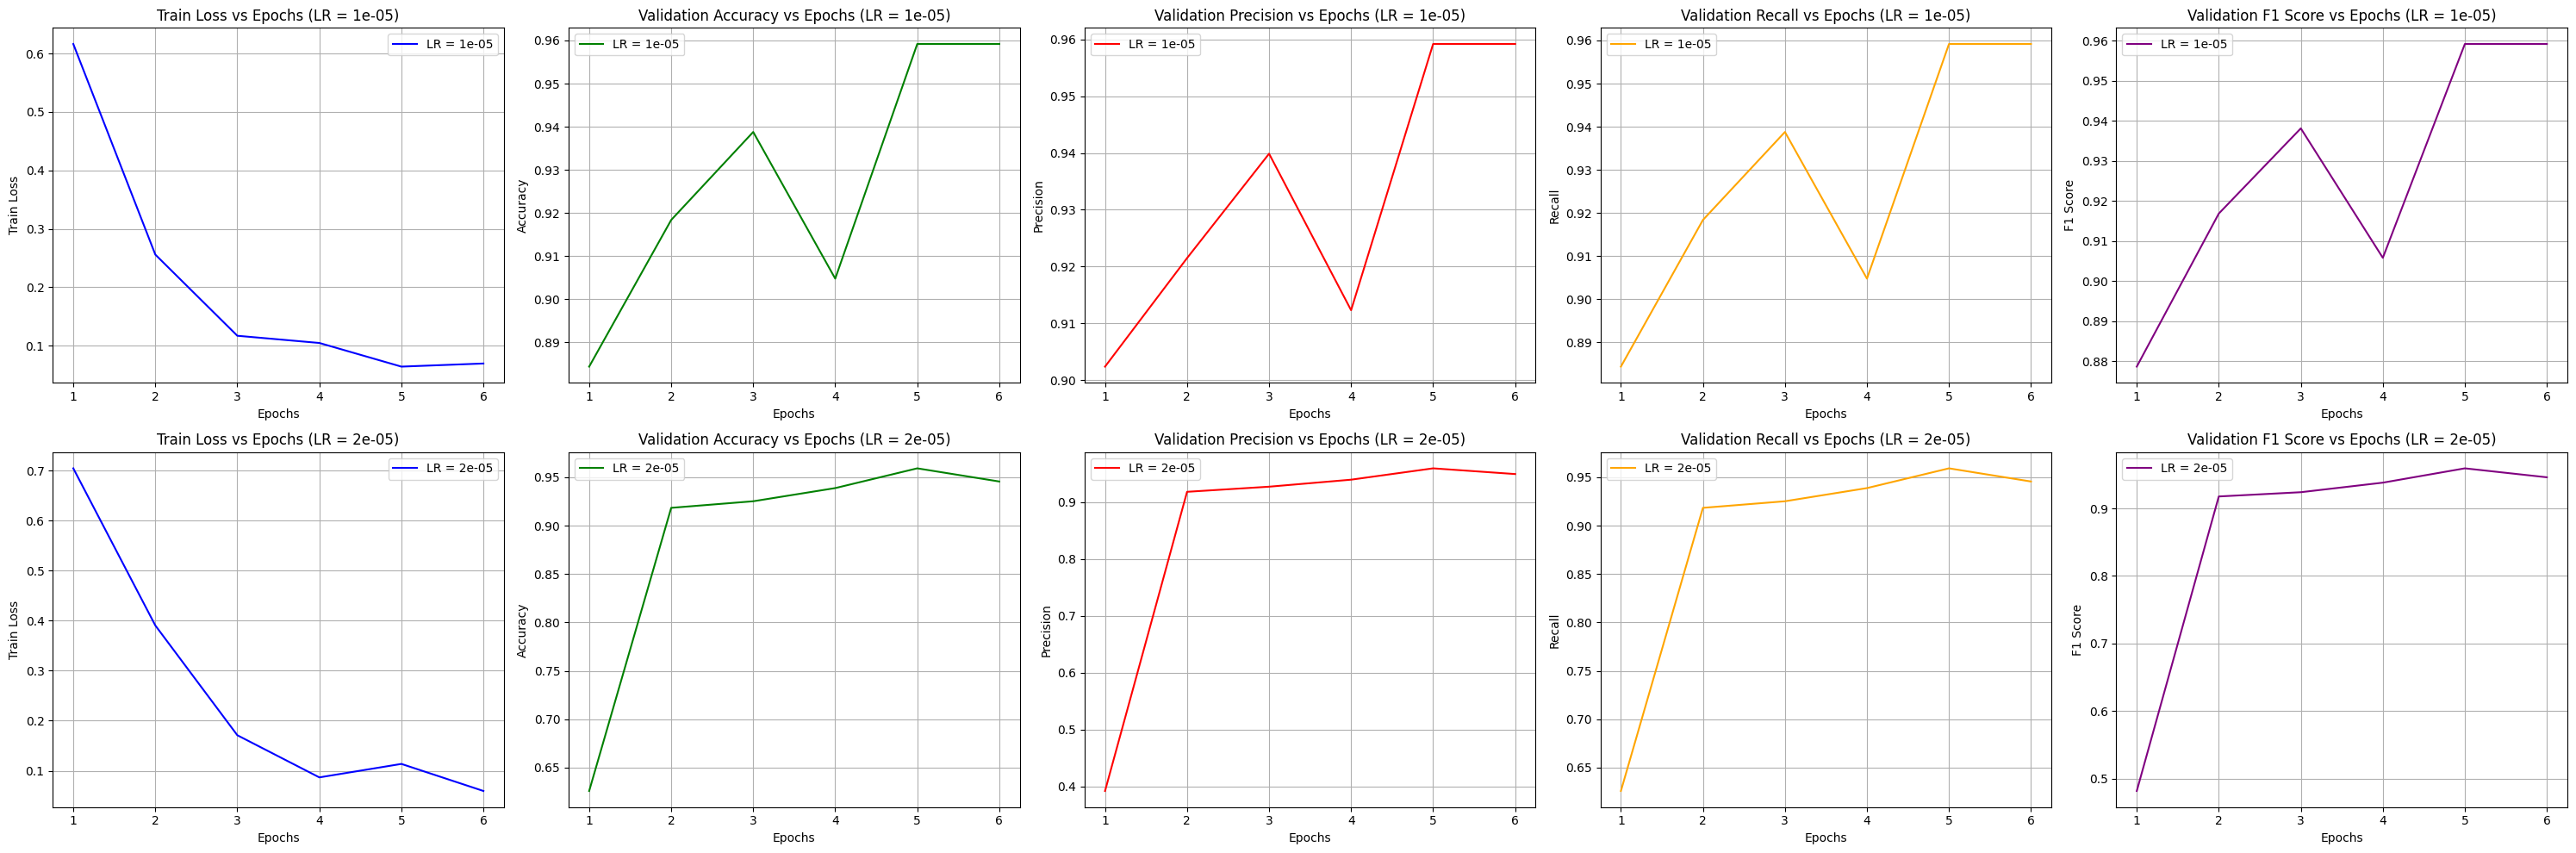

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('training_metrics_xlm-roberta-base.csv')

# Obtener los valores únicos de learning rate
learning_rates = df['Learning Rate'].unique()

# Crear la figura y los ejes
num_rows = len(learning_rates)
num_cols = 5  # Number of columns (plots per LR)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten axes if there's only one row (one learning rate)
if num_rows == 1:
    axes = axes.reshape(1, num_cols) # Reshape to 2D array even if it's one row.

# Iterar sobre cada valor de learning rate
for i, lr in enumerate(learning_rates):
    # Filtrar los datos para este learning rate
    lr_data = df[df['Learning Rate'] == lr]

    # Entrenamiento vs Pérdida
    axes[i, 0].plot(lr_data['Epoch'], lr_data['Train Loss'], label=f'LR = {lr}', color='blue')
    axes[i, 0].set_title(f'Train Loss vs Epochs (LR = {lr})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Train Loss')
    axes[i, 0].grid(True)
    axes[i, 0].legend()  # Add legend

    # Precisión de validación
    axes[i, 1].plot(lr_data['Epoch'], lr_data['Validation Accuracy'], label=f'LR = {lr}', color='green')
    axes[i, 1].set_title(f'Validation Accuracy vs Epochs (LR = {lr})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].grid(True)
    axes[i, 1].legend()

    # ... (Repeat for other metrics - Precision, Recall, F1)
    axes[i, 2].plot(lr_data['Epoch'], lr_data['Precision'], label=f'LR = {lr}', color='red')
    axes[i, 2].set_title(f'Validation Precision vs Epochs (LR = {lr})')
    axes[i, 2].set_xlabel('Epochs')
    axes[i, 2].set_ylabel('Precision')
    axes[i, 2].grid(True)
    axes[i, 2].legend()

    axes[i, 3].plot(lr_data['Epoch'], lr_data['Recall'], label=f'LR = {lr}', color='orange')
    axes[i, 3].set_title(f'Validation Recall vs Epochs (LR = {lr})')
    axes[i, 3].set_xlabel('Epochs')
    axes[i, 3].set_ylabel('Recall')
    axes[i, 3].grid(True)
    axes[i, 3].legend()

    axes[i, 4].plot(lr_data['Epoch'], lr_data['F1 Score'], label=f'LR = {lr}', color='purple')
    axes[i, 4].set_title(f'Validation F1 Score vs Epochs (LR = {lr})')
    axes[i, 4].set_xlabel('Epochs')
    axes[i, 4].set_ylabel('F1 Score')
    axes[i, 4].grid(True)
    axes[i, 4].legend()


plt.tight_layout()
plt.show()